In [2]:
import bento
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from hmr import Reloader

bento = Reloader(bento)

# Load MERFISH dataset

In [3]:
adata = bento.datasets.load_dataset("merfish_raw")

# Quality Control

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)
bento.tl.cell_area(adata)
bento.tl.cell_density(adata)

AnnData object modified:
    obs:
        + cell_area
AnnData object modified:
    obs:
        + cell_density


## Figure 1C

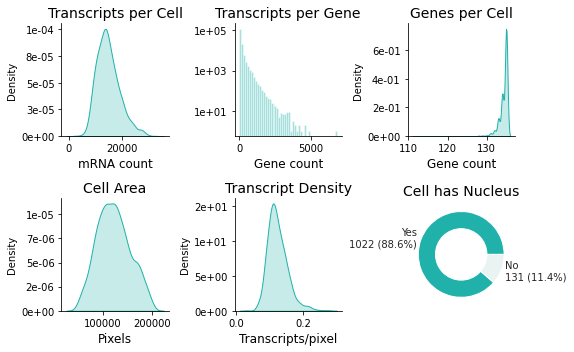

In [5]:
bento.pl.qc_metrics(adata)

Filter out cells without a nucleus.

In [6]:
adata = adata[adata.obs["nucleus_shape"] != None]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


In [7]:
adata

AnnData object with n_obs × n_vars = 1022 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'cell_area', 'cell_density'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'points'
    layers: 'spliced', 'unspliced'

In [8]:
valid_genes = adata.var_names[(adata.to_df() >= 10).sum() >= 1]

adata = adata[:, valid_genes]
bento.pp.set_points(adata)

Trying to set attribute `.uns` of view, copying.


In [10]:
bento.reload()
bento.tl.lp(adata, min_count=5)

Cell features:   0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_maxy, cell_miny, cell_radius, cell_raster, cell_minx, cell_maxx, cell_span
gene
nucleus
batch
[########################################] | 100% Completed | 25min 55.0s
AnnData object modified:
    obs:
        + cell_edge_fraction, none_fraction, cell_minx, nuclear_fraction, nuclear_edge_fraction, cell_miny, cell_radius, cell_raster, none_count, n_detected, cell_span, nuclear_edge_count, fraction_detected, nuclear_count, cytoplasmic_fraction, cell_edge_count, cell_maxy, cell_maxx, cytoplasmic_count
    var:
        + cell_edge_count, nuclear_edge_count, fraction_detected, cell_edge_fraction, none_count, nuclear_count, none_fraction, n_detected, nuclear_edge_fraction, cytoplasmic_fraction, nuclear_fraction, cytoplasmic_count
    layers:
        + cell_outer_proximity, nuclear_edge_p, nuclear, nucleus_outer_proximity, none_p, none, l_max_gradient, cell_inner_asymmetry, nuclear_edge, cell_inner_proximity, l_max, nucleus_inner_asymmetry, nuc

## Figure 2

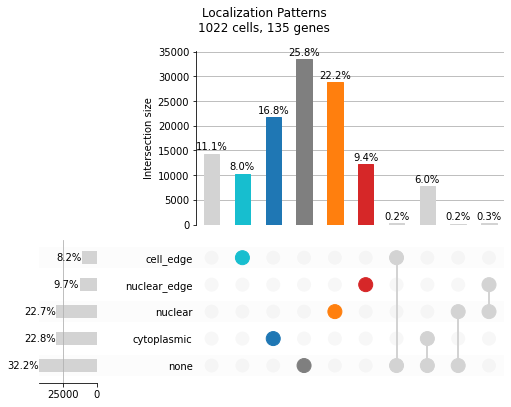

In [11]:
bento.pl.lp_dist(adata, percentage=True)

No handles with labels found to put in legend.


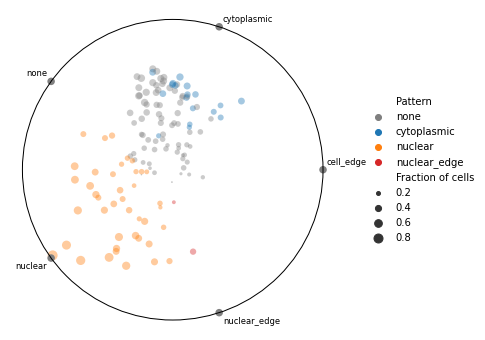

In [12]:
bento.pl.lp_genes(adata, alpha=0.4)

# Tensor decomposition

AnnData object modified:
    uns:
        + tensor, tensor_labels
Device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

The rank at the elbow is: 2
[(1, array(0.86379427)), (2, array(0.80990591)), (3, array(0.79604285)), (4, array(0.77995932)), (5, array(0.77048312))]


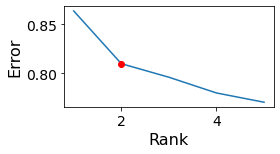

In [13]:
bento.reload()

bento.tl.select_tensor_rank(
    adata, bento.PATTERN_NAMES, upper_rank=5, runs=1
)

In [15]:
bento.reload()
bento.tl.lp_signatures(adata, 3)

Device: cuda
AnnData object modified:
    obs:
        + td_cluster
    var:
        + td_cluster
    uns:
        + tensor_loadings


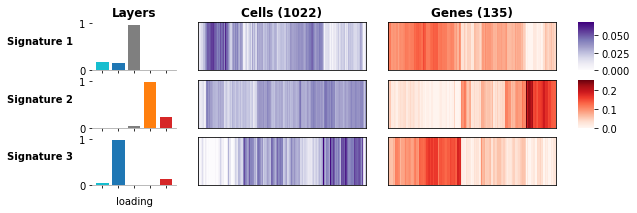

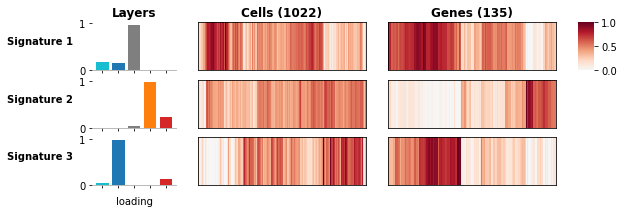

In [16]:
bento.pl.lp_signatures(adata, scale=False)
bento.pl.lp_signatures(adata, scale=True)

In [17]:
@bento.pl._utils.savefig
def plot_signature(data, id, fname=None):

    # Setup plot
    fig, axs = plt.subplots(
        2,
        4,
        figsize=(4, 3.6),
        gridspec_kw=dict(
            height_ratios=[1, 8], width_ratios=[1, 8, 0.5, 0.5], hspace=0, wspace=0
        ),
    )
    axs[0, 0].remove()
    axs[0, 2].remove()
    axs[0, 3].remove()
    axs[1, 2].remove()
    gene_ax = axs[0, 1]
    cell_ax = axs[1, 0]

    joint_ax = axs[1, 1]
    cbar_ax = axs[1, 3]

    gene_ax.xaxis.set_label_position("top")
    cell_ax.yaxis.set_label_position("left")

    joint_ax.sharex(gene_ax)
    joint_ax.sharey(cell_ax)

    cell_order = data.obs["td_cluster"].sort_values().index
    gene_order = data.var["td_cluster"].sort_values().index

    cell_loadings = np.log2(adata.uns["tensor_loadings"]["cells"] + 1)
    gene_loadings = np.log2(adata.uns["tensor_loadings"]["genes"] + 1)

    signature_mtx = np.dot(
        cell_loadings[id].values.reshape(-1, 1),
        gene_loadings[id].values.reshape(1, -1),
    )
    # signature_mtx = np.log2(signature_mtx + 1)
    signature_mtx = pd.DataFrame(
        signature_mtx, index=cell_loadings.index, columns=gene_loadings.index
    )
    signature_mtx = signature_mtx.loc[cell_order, gene_order]

    ar = np.sqrt(float(len(cell_loadings) / len(gene_loadings)))
    figsize = (10, 10 * ar)

    sns.heatmap(
        gene_loadings.loc[gene_order, [id]].T,
        cmap="Reds",
        ax=gene_ax,
        yticklabels=False,
        cbar=None,
        rasterized=True,
    )
    sns.heatmap(
        cell_loadings.loc[cell_order, [id]],
        cmap="Reds",
        ax=cell_ax,
        xticklabels=False,
        cbar=None,
        rasterized=True,
    )

    sns.heatmap(
        signature_mtx,
        cmap="Reds",
        xticklabels=False,
        yticklabels=False,
        cbar_ax=cbar_ax,
        ax=joint_ax,
        rasterized=True
        # figsize=figsize,
    )
    joint_ax.set(xlabel=None, ylabel=None)
    sns.despine(ax=gene_ax, top=False, bottom=False, left=False, right=False)
    sns.despine(ax=cell_ax, top=False, bottom=False, left=False, right=False)
    sns.despine(ax=joint_ax, top=False, bottom=False, left=False, right=False)

    plt.suptitle(id, weight="600")

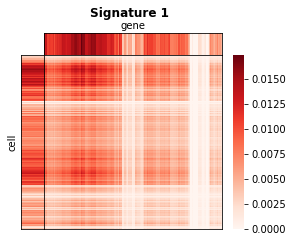

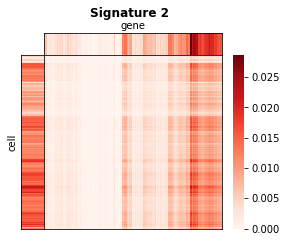

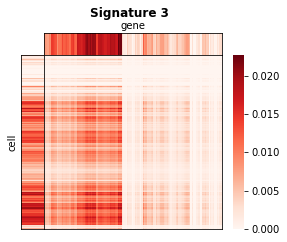

In [18]:
for sig, name in zip(
    adata.uns["tensor_loadings"]["layers"].columns, ["sig1", "sig2", "sig3"]
):
    plot_signature(adata, sig)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

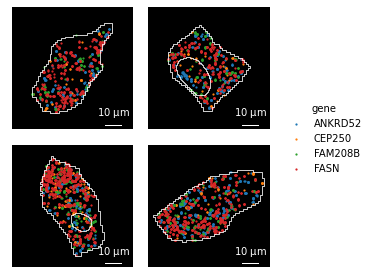

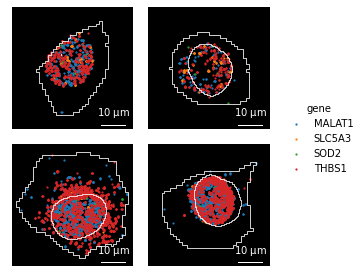

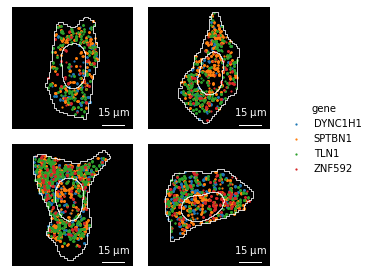

In [19]:
bento.pl.sig_samples(adata, n=4)

# Interpret gene loadings

In [20]:
gene_loadings = adata.uns["tensor_loadings"]["genes"]

## Gene set enrichment

In [21]:
import gseapy as gp
from scipy.stats import zscore

In [22]:
def gsea_top_pathways(gene_loadings, library):
    gene_loadings = gene_loadings.reset_index()
    gene_loadings["index"] = gene_loadings["index"].str.upper().astype(str)
    gene_loadings = gene_loadings.set_index("index")
    gene_loadings = gene_loadings.apply(zscore)

    top_enriched = []

    gsea_out = gp.ssgsea(
        gene_loadings,
        library,
        processes=8,
        min_size=10,
        no_plot=True,
        seed=6,
        verbose=True,
    )
    gsea_out.res2d.index = [i.split("(")[0] for i in gsea_out.res2d.index]
    top_enriched = []
    for f in gsea_out.res2d.columns:
        top_enriched.extend(gsea_out.res2d.sort_values(f).tail(5).index)

    top_enriched = list(set(top_enriched))

    plt.rcParams["figure.dpi"] = 100
    g = sns.clustermap(
        gsea_out.res2d.loc[top_enriched], cmap="RdBu_r", center=0, figsize=(6, 8)
    )
    # g.ax_heatmap.axis('on')
    g.ax_heatmap.tick_params(axis="both", which="both", length=0)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), size=12)

### Loading enrichment

2022-06-28 11:58:31,550 Parsing data files for ssGSEA...........................
2022-06-28 11:58:32,307 Enrichr library gene sets already downloaded in: /cellar/users/ckmah/.cache/gseapy, use local file
2022-06-28 11:58:32,591 0506 gene_sets have been filtered out when max_size=2000 and min_size=10
2022-06-28 11:58:32,591 0005 gene_sets used for further statistical testing.....
2022-06-28 11:58:32,592 Start to run ssGSEA...Might take a while................
2022-06-28 11:58:32,893 Calculate Enrichment Score for Sample: Signature 1 
2022-06-28 11:58:32,894 Calculate Enrichment Score for Sample: Signature 2 
2022-06-28 11:58:32,895 Calculate Enrichment Score for Sample: Signature 3 
2022-06-28 11:58:32,897 Congratulations. GSEApy runs successfully................



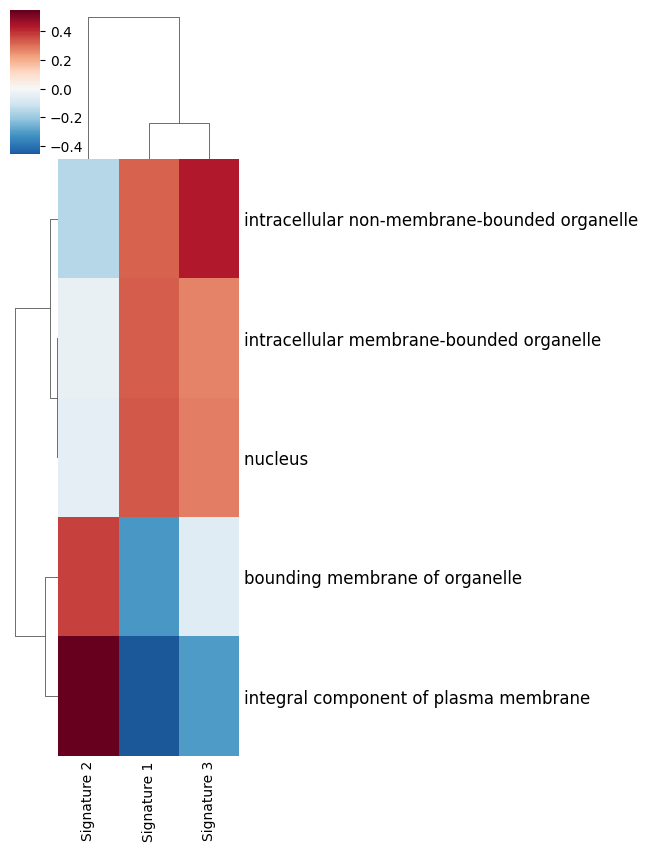

In [23]:
go_cc = gsea_top_pathways(gene_loadings, "GO_Cellular_Component_2021")

In [24]:
gene_loadings.index.name = None

2022-06-28 11:58:34,432 Parsing data files for ssGSEA...........................
2022-06-28 11:58:34,951 Enrichr library gene sets already downloaded in: /cellar/users/ckmah/.cache/gseapy, use local file
2022-06-28 11:58:35,208 0506 gene_sets have been filtered out when max_size=2000 and min_size=10
2022-06-28 11:58:35,208 0005 gene_sets used for further statistical testing.....
2022-06-28 11:58:35,209 Start to run ssGSEA...Might take a while................
2022-06-28 11:58:35,450 Calculate Enrichment Score for Sample: Signature 1 
2022-06-28 11:58:35,451 Calculate Enrichment Score for Sample: Signature 2 
2022-06-28 11:58:35,452 Calculate Enrichment Score for Sample: Signature 3 
2022-06-28 11:58:35,453 Congratulations. GSEApy runs successfully................



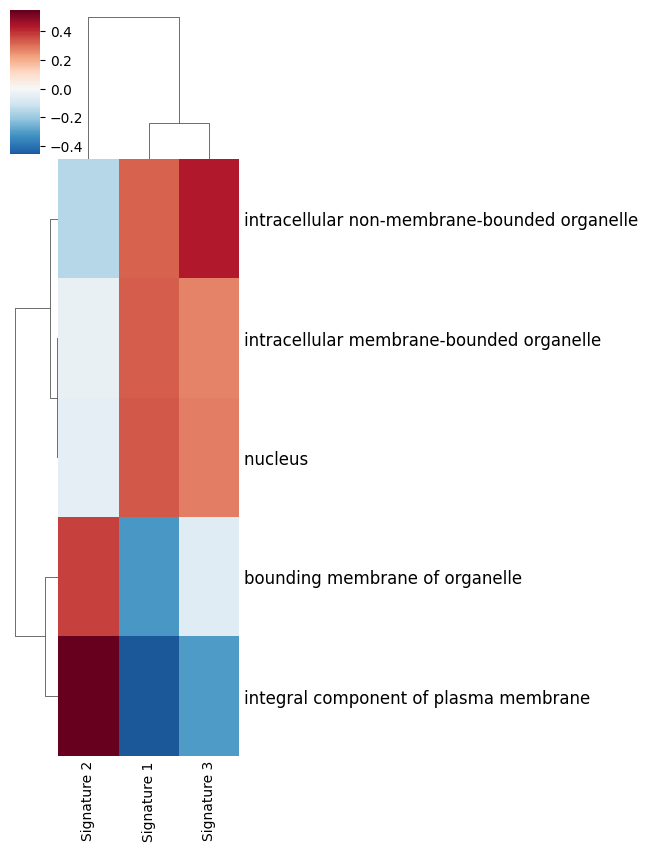

In [25]:
gsea_top_pathways(gene_loadings, "GO_Cellular_Component_2021")

# Interpet cell loadings

## morphology

In [26]:
from scipy.stats import zscore

In [27]:
cell_loadings = adata.uns["tensor_loadings"]["cells"]

In [28]:
cell_expr = adata.to_df()
cell_expr = np.log10(cell_expr[cell_expr >= 10] + 1).sum(axis=1).to_frame()
cell_expr.columns = ["log10(total cell expr)"]

expression = adata.to_df()
expression = np.log10(expression[expression >= 10] + 1).sum().to_frame()
expression.columns = ["log10(total cell expr)"]
expression.shape

(135, 1)

In [29]:
morph_names = [
    "cell_perimeter",
    "cell_area",
    "cell_aspect_ratio",
    "nucleus_area",
    "nucleus_area_ratio",
    "nucleus_aspect_ratio",
    "nucleus_offset",
]
bento.tl.analyze_cells(adata, morph_names)
morph_features = adata.obs[morph_names]

  0%|          | 0/7 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_area, cell_aspect_ratio, cell_perimeter, nucleus_aspect_ratio, nucleus_offset, nucleus_area_ratio


In [30]:
cell_measures = pd.concat([morph_features, cell_expr], axis=1).iloc[:, ::-1]

In [31]:
import pingouin as pg


def corr_loadings(loadings, phenotypes, height=6, aspect=0.5, fname=""):
    """
    Dotplot showing correlation of loadings to phenotypes.
    Hue denotes correlation, size denotes fraction of cells with phenotype.
    """
    data = pd.concat([loadings, phenotypes], axis=1)

    corr_long = data.pairwise_corr(
        columns=[loadings.columns.tolist(), phenotypes.columns.tolist()],
        method="spearman",
        padjust="holm",
    )[["X", "Y", "r", "p-unc", "p-corr"]]

    # -log10p for interpretation
    corr_long["-log10(fdr)"] = -np.log10(corr_long["p-corr"].astype(float) + 1e-3)
    corr_long["-log10(fdr)"] = (
        corr_long["-log10(fdr)"].map("{:,.2f}".format).astype(float)
    )

    with sns.axes_style("ticks"):
        g = sns.relplot(
            data=corr_long,
            x="X",
            y="Y",
            size="-log10(fdr)",
            sizes=(20, 800),
            size_norm=(0, 3),
            hue="r",
            hue_norm=(-1, 1),
            aspect=aspect,
            height=height,
            palette="RdBu_r",
            legend="auto",
        )

        ax = g.ax
        g.set(
            xlim=(-0.5, float(loadings.shape[1]) - 0.5),
            ylim=(-0.5, float(phenotypes.shape[1]) - 0.5),
            xlabel="",
            ylabel="",
        )
        ax.tick_params(axis="x", rotation=30)
        sns.despine(ax=ax, top=False, right=False)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
        ax.grid(visible=None, which="major", axis="both")
        # plt.tight_layout()

        rc = {"svg.fonttype": "none", "font.family": "Arial"}
        if fname:
            with plt.rc_context(rc):
                plt.savefig(fname)

    return corr_long

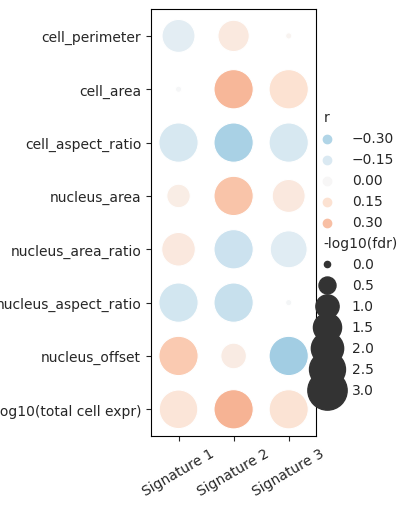

In [32]:
cell_corr = corr_loadings(
    cell_loadings,
    cell_measures,
    height=5,
    aspect=0.77,
)